In [1]:
PATH_TO_TENSORFLOW_MODEL_REPO = '/location/of/repo'

In [2]:
import sys
import os

In [3]:
sys.path.append(os.path.join(PATH_TO_TENSORFLOW_MODEL_REPO, 'research/slim/'))
sys.path.append(os.path.join(PATH_TO_TENSORFLOW_MODEL_REPO, 'research/'))

In [4]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from mtcnn import detect_face
from ssd import object_detection

In [5]:
client = object_detection.ObjectDetector('./ssd/frozen_inference_graph.pb')

In [6]:
sess = tf.InteractiveSession()
o =  detect_face.create_onet(sess, "./mtcnn/det3.npy")

In [7]:
img = np.array(Image.open('img/img.jpg'))

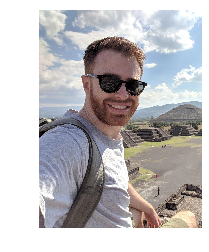

In [8]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
def make_square(l, r, t, b):
    square_side = max(r - l, t - b)
    nr = (r + l)/2 + (square_side/2)
    nl = (r + l)/2 - (square_side/2)
    nt = (t + b)/2 + (square_side/2)
    nb = (t + b)/2 - (square_side/2)
    return nl, nr, nt, nb

def make_box(img, top, left, bottom, right):
    img_h, img_w, _ =  img.shape
    center_y, center_x = (top + bottom)/2.0, (left + right)/2.0
    org_h, org_w = (bottom - top), (right - left)
    out_hw = max(org_h, org_w)
    if (out_hw > img_h)|(out_hw > img_w):
        print("can't make square") # error
    if (center_y - (out_hw / 2.0)) < 0:
        center_y = out_hw / 2.0
    if (center_y + (out_hw / 2.0)) > img_h:
        center_y = img_h - (out_hw / 2.0)
    if (center_x - (out_hw / 2.0)) < 0:
        center_x = out_hw / 2.0
    if (center_x + (out_hw / 2.0)) > img_w:
        center_x = img_h - (out_hw / 2.0)
    return (int(center_y - (out_hw / 2.0)), 
            int(center_x - (out_hw / 2.0)), 
            int(center_y + (out_hw / 2.0)), 
            int(center_x + (out_hw / 2.0)))

def adjust_input(img, dims = (48,48)):
    resize = cv2.resize(img, dims)
    expanded = np.expand_dims(resize, 0)
    adjust_for_caffe = np.transpose(expanded, (0,2,1,3))
    recenter = (adjust_for_caffe-127.5)*0.0078125
    return(recenter)

In [10]:
def get_faces(img, ssd_thresh=0.5, onet_thresh=0.8):
    boxes, scores, _, _ = client.detect(img)
    filtered_boxes = boxes[scores > ssd_thresh]
    
    im_height, im_width, _ = img.shape

    for box in filtered_boxes:
        ymin, xmin, ymax, xmax = box
        (l, r, t, b) = (xmin * im_width, xmax * im_width,
                        ymin * im_height, ymax * im_height)
        #import pdb; pdb.set_trace()
        nl, nr, nt, nb = make_square(l, r, t, b)
        square_side = nr - nl
        just_face = img[int(nb):int(nt), int(nl):int(nr), :]
        o_out = o(adjust_input(just_face))
        
        if o_out[2][0][1] > onet_thresh:
            al, ar, ab, at = (nl + o_out[0][0][0]*square_side,nr + o_out[0][0][2]*square_side, 
                nb + o_out[0][0][1]*square_side,nt +o_out[0][0][3]*square_side)
            plt.imshow(img[int(ab):int(at), int(al):int(ar), :])
            plt.axis('off')
            plt.show()

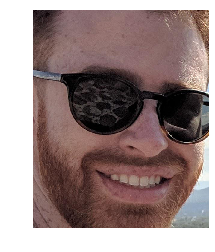

In [11]:
get_faces(img)